In [ ]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer

# Tic Toc Toe environment

Our 1st game is the famous Tic Toc Toe. You can read about the game and its rules here: https://en.wikipedia.org/wiki/Tic-tac-toe

We implemented the game as an environment in the style of games in the [Python GYM library](https://gym.openai.com/). The commented source code is available in the file "tic_env.py". Here, we give a brief introduction to the environment and how it can be used.

### Initialization and attributes

You can initialize the environment / game as following:

In [ ]:
env = TictactoeEnv()

Which then has the following attributes with the corresponding initial values:

In [ ]:
env.__dict__

The game is played by two players: player 'X' and player 'O'. The attribute 'current_player' shows whose turn it is. We assume that player 'X' always plays first.

The attribute 'grid' is a 3x3 numpy array and presents the board in the real game and the state $s_t$ in the reinfocement learning language. Each elements can take a value in {0, 1, -1}:
     0 : place unmarked
     1 : place marked with X 
    -1 : place marked with O 
        
The attribute 'end' shows if the game is over or not, and the attribute 'winner' shows the winner of the game: either "X", "O", or None.  

You can use function 'render' to visualize the current position of the board:

In [ ]:
env.render()

### Taking actions

The game environment will recieve action from two players in turn and update the grid. At each time, one player can take the action $a_t$, where $a_t$ can either be an integer between 0 to 8 or a touple, corresponding to the 9 possible.

Function 'step' is used to recieve the action of the player, update the grid:

In [ ]:
env.step(2)

In [ ]:
env.render()

In [ ]:
env.__dict__

In [ ]:
env.step((1,1))

In [ ]:
env.render()

In [ ]:
env.__dict__

But not all actions are available at each time: One cannot choose a place which has been taken before. There is an error if an unavailable action is taken:

In [ ]:
# env.step((0,2))

### Reward

Reward is always 0 until the end of the game. When the game is over, the reward is 1 if you win the game, -1 if you lose, and 0 besides. Function 'observe' can be used after each step to recieve the new state $s_t$, whether the game is over, and the winner, and function 'reward' to get the reward value $r_t$:

In [ ]:
env.observe()

In [ ]:
env.reward(player='X')

In [ ]:
env.reward(player='O')

An example of finishing the game:

In [ ]:
env.step(0)
env.step(3)
env.step(1)

In [ ]:
env.render()

In [ ]:
env.observe()

In [ ]:
env.reward(player='X')

In [ ]:
env.reward(player='O')

# Optimal policy for Tic Toc Toe environment

Fortunately, we know the exact optimal policy for Tic Toc Toe. We have implemented and $\epsilon$-greedy version of optimal polciy which you can use for the project.

In [ ]:
env.reset();

In [ ]:
opt_player = OptimalPlayer(epsilon = 0., player = 'X')

In [ ]:
opt_player.act(env.grid)

In [ ]:
opt_player.player

### An example of optimal player playing against random player

In [ ]:
Turns = np.array(['X','O'])
for i in range(5):
    env.reset()
    grid, _, __ = env.observe()
    Turns = Turns[np.random.permutation(2)]
    player_opt = OptimalPlayer(epsilon=0., player=Turns[0])
    player_rnd = OptimalPlayer(epsilon=1., player=Turns[1])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt.act(grid)
        else:
            move = player_rnd.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player = ' +  Turns[0])
            print('Random player = ' +  Turns[1])
            env.render()
            env.reset()
            break


### An example of optimal player playing against optimal player

In [ ]:
Turns = np.array(['X','O'])
for i in range(5):
    env.reset()
    grid, _, __ = env.observe()
    Turns = Turns[np.random.permutation(2)]
    player_opt_1 = OptimalPlayer(epsilon=0., player=Turns[0])
    player_opt_2 = OptimalPlayer(epsilon=0., player=Turns[1])
    for j in range(9):
        if env.current_player == player_opt_1.player:
            move = player_opt_1.act(grid)
        else:
            move = player_opt_2.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player 1 = ' +  Turns[0])
            print('Optimal player 2 = ' +  Turns[1])
            env.render()
            env.reset()
            break


# Question 1
In this section, you will study whether Q-learning can learn to play Tic Tac Toe by playing against
Opt(eps_opt) for some eps_opt ∈ [0, 1]. To do so, implement the Q-learning algorithm. To check the algorithm,
run a Q-learning agent, with a fixed and arbitrary eps ∈ [0, 1), against Opt(0.5) for 20’000 games – switch
the 1st player after every game.
Question 1. Plot average reward for every 250 games during training – i.e. after the 50th game, plot
the average reward of the first 250 games, after the 100th game, plot the average reward of games 51 to
100, etc. Does the agent learn to play Tic Tac Toe?
Expected answer: A figure of average reward over time (caption length < 50 words). Specify your choice
of eps.

In [ ]:
import random

class QLearntPlayer:
    def __init__(self, game_env: TictactoeEnv, epsilon: float, discount_rate_gamma = 0.99, learning_rate_alpha = 0.5):
        self.game_env = game_env
        self.epsilon = epsilon
        self.discount_rate_gamma = discount_rate_gamma
        self.learning_rate_alpha = learning_rate_alpha
        self.Q_values = {Turns[0]: {}, Turns[1]: {}}
        self.prev_move = None
        self.prev_grid = None
        self.player = None # 'X' or 'O'
        self.player_Q_values = None

    def get_empty_positions(self, grid):
        '''return all empty positions'''
        avail = []
        for i in range(9):
            pos = (int(i/3), i % 3)
            if grid[pos] == 0:
                avail.append(pos)
        return avail

    def hash_grid(self, grid: np.ndarray):
        return grid.tobytes()

    def prepare_new_game_(self, player):
        self.prev_move = None
        self.prev_grid = None
        self.curr_grid = None
        self.curr_move = None
        assert player == 'X' or player == 'O'
        self.player = player
        self.player_Q_values = self.Q_values[player]
        return self

    def get_max_val_action(self, possible_moves, grid_hash):
        if len(possible_moves) == 0:
            q_val = self.player_Q_values[grid_hash]['']
            assert type(q_val) is int
            return ''
        return max(possible_moves, key=self.player_Q_values[grid_hash].get)

    def init_q_values_(self, grid_hash, possible_moves):
        if grid_hash not in self.player_Q_values:
            self.player_Q_values[grid_hash] = {} if len(possible_moves) > 0 else {'': 0}
        for mv in possible_moves:
            if mv not in self.player_Q_values[grid_hash]: self.player_Q_values[grid_hash][mv] = 0

    def choose_move_(self, grid):
        grid_hash = self.hash_grid(grid)
        # Get moves
        possible_moves = self.get_empty_positions(grid)
        assert len(possible_moves) > 0
        # Init Q_values
        self.init_q_values_(grid_hash, possible_moves)
        # Choose move (eps.greedy)
        if random.random() >= self.epsilon:
            chosen_move = self.get_max_val_action(possible_moves, grid_hash)
        else:
            chosen_move = random.choice(possible_moves)
        self.curr_grid = grid
        self.curr_move = chosen_move
        return chosen_move

    def update_q_values_(self, new_grid):
        """
        update Q values by Q-learning formula.

        new_grid ~ S' in the formula
        """
        prev_grid, prev_move = self.prev_grid, self.prev_move
        self.prev_grid = self.curr_grid
        self.prev_move = self.curr_move
        self.curr_grid, self.curr_move = None, None
        if prev_grid is not None and prev_move is not None:
            new_grid_hash = self.hash_grid(new_grid)
            prev_grid_hash = self.hash_grid(prev_grid)
            reward = self.game_env.reward(self.player)
            # Get max_a (Q(S', a))
            possible_moves_s_dash = self.get_empty_positions(new_grid)
            self.init_q_values_(new_grid_hash, possible_moves_s_dash)
            max_val_action = self.get_max_val_action(possible_moves_s_dash, new_grid_hash)
            max_q_value = self.player_Q_values[new_grid_hash][max_val_action]

            # Update according to Q-learning formula
            prev_q_val = self.player_Q_values[prev_grid_hash][prev_move]
            self.player_Q_values[prev_grid_hash][prev_move] += self.learning_rate_alpha*(reward + self.discount_rate_gamma*max_q_value - prev_q_val)

In [ ]:
def run_n_games(max_games_number, our_player, opponent_epsilon, our_player_new_game_epsilon, update_q_values, progress_print=None):
    _rewards = [None for _ in range(max_games_number)]
    _turns = ['X','O']
    opponent =  OptimalPlayer(epsilon=opponent_epsilon, player=_turns[0])

    for game in range(max_games_number):
        if progress_print and game % progress_print == 0:
            print('Game ', game, ' begins.')
        env.reset()
        grid, _, __ = env.observe()
        _turns = _turns[::-1] # Reverse after every game to ensure both sides played equally
        opponent.player = _turns[0]
        our_player = q_learnt_player.prepare_new_game_(_turns[1])
        assert opponent.player != our_player.player
        our_player.epsilon = our_player_new_game_epsilon(game_number_n=game)

        for turn in range(9):
            opponent_turn = env.current_player == opponent.player
            if opponent_turn:
                chosen_move = opponent.act(grid)
            else:
                chosen_move = our_player.choose_move_(grid)

            grid, end, winner = env.step(chosen_move, print_grid=False)

            if opponent_turn:
                update_q_values and q_learnt_player.update_q_values_(grid)
            if end:
                update_q_values and q_learnt_player.update_q_values_(grid)
                _rewards[game] = env.reward(our_player.player)
                break
    return _rewards

In [ ]:
import matplotlib.pyplot as plt

max_games = 20000
q_learnt_player = QLearntPlayer(env, epsilon=0.2)
avgs = []
rewards = []
total_wins = 0

for game_epoch in range(max_games//250):
    if game_epoch % 10 == 0:
        print('Game ', game_epoch*250, ' begins.')
    run_rewards = run_n_games(max_games_number=250, our_player=q_learnt_player, opponent_epsilon=0.5, \
            our_player_new_game_epsilon=lambda game_number_n: 0.2, update_q_values=True)
    rewards+=run_rewards
    avgs.append(np.average(run_rewards))
    total_wins += sum(1 if rew ==1 else 0 for rew in run_rewards)

print('Our agent won {} times'.format(total_wins))
plt.figure(figsize=(15,15))
ax = plt.plot(avgs)
plt.xticks(ticks=range(len(avgs)), labels=[str(x*250 // 1000) if x*250 % 1000 == 0 else '' for x in range(len(avgs))])
plt.ylabel('Average reward per 250 episodes')
plt.xlabel('Episode (thousands)')
plt.show()

Question 2. Plot average reward for every 250 games during training. Does decreasing epsilon help training
compared to having a fixed epsilon? What is the effect of n∗?
Expected answer: A figure showing average reward over time for different values of n∗ (caption length < 200 words)

In [ ]:
max_games = 20000
n_stars =  np.geomspace(1, 40000, num=4) # Includes 1 and 40000
epoch_size = 250

rewards = {n_star: [] for n_star in n_stars}
M_opt = {n_star: [] for n_star in n_stars}
M_rand = {n_star: [] for n_star in n_stars}

min_epsilon = 0.1
max_epsilon = 0.8
def calc_epsilon_factory(n_star, epoch_size, game_epoch):
        def calc_epsilon(game_number_n):
            real_game_number = game_epoch*epoch_size + game_number_n
            return max(min_epsilon, max_epsilon*(1-(real_game_number/n_star)))
        return calc_epsilon

for n_star in n_stars:
    q_learnt_player = QLearntPlayer(env, epsilon=max_epsilon)
    print('Current n_star = {}'.format(n_star))

    for game_epoch in range(max_games//epoch_size):
        calc_epsilon = calc_epsilon_factory(n_star=n_star, epoch_size=epoch_size, game_epoch=game_epoch)
        if game_epoch % 20 == 0:
            print('Game ', game_epoch*epoch_size, ' begins.')

        # Run 250 games with updating Q-vals and observe reward (exec 2)
        run_rewards = run_n_games(max_games_number=epoch_size, our_player=q_learnt_player, opponent_epsilon=0.5, \
            our_player_new_game_epsilon=calc_epsilon, update_q_values=True)
        rewards[n_star] += run_rewards

        # Run 500 games for M_opt calculation
        M_opt_rewards = run_n_games(max_games_number=500, our_player=q_learnt_player, opponent_epsilon=0, \
            our_player_new_game_epsilon=lambda game_number_n: 0, update_q_values=False)
        M_opt[n_star].append(np.average(M_opt_rewards))


        # Run 500 games for M_rand calculation
        M_rand_rewards = run_n_games(max_games_number=500, our_player=q_learnt_player, opponent_epsilon=1, \
            our_player_new_game_epsilon=lambda game_number_n: 0, update_q_values=False)
        M_rand[n_star].append(np.average(M_rand_rewards))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
avgs = {n_star: [] for n_star in n_stars}
for x in range(0,max_games, 250):
    lower_index = x
    upper_index = min(x+250, max_games-1)
    for n_star in n_stars:
        slice = rewards[n_star][lower_index:upper_index]
        avgs[n_star].append(sum(slice)/len(slice))

q2_data = pd.DataFrame(avgs)
q2_data.index.name = 'epochs by 250'
q2_data.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q2_data)
g.set_ylabel('Average rewards per 250 epochs')

In [ ]:
# Print the same plot as in exe 1 to ensure results are the same

plt.figure(figsize=(15,15))
ax = plt.plot(avgs[1.0])
plt.xticks(ticks=range(len(avgs[1.0])), labels=[str(x*250 // 1000) if x*250 % 1000 == 0 else '' for x in range(len(avgs[1.0]))])
plt.ylabel('Average reward per 250 episodes')
plt.xlabel('Episode (thousands)')
plt.show()

In [ ]:
for (n_star, rews) in rewards.items():
    print('{} won {} games'.format(n_star, sum(1 if rew ==1 else 0 for rew in rews)))

In [ ]:
len(rewards[1.0])

#### Q2
*Does decreasing epsilon help with training compared to fix epsilon?*

(jl, April 22, 8:00pm)  **I cannot see a bug but it seems it virtually does not, which is very counterintuitive.** But the best value we seem to observe is when n_star = 1 but that is the same as not having any decrease at all and just hardcoding epsilon to 0.1. This is very strange indeed.


*What is the effect of n\*?*

Based on our small sample of 4 n*, it seems the smaller n* the better: n*=1 gets better perf than n*=34.2 which in turn gets better than n*=1169 which is in turn much better than n*=40,000.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

M_opt_df = pd.DataFrame(M_opt)
M_opt_df.index.name = 'epochs by 250'
M_opt_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=M_opt_df)
g.set_ylabel('M_opt')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

M_rand_df = pd.DataFrame(M_rand)
M_rand_df.index.name = 'epochs by 250'
M_rand_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=M_rand_df)
g.set_ylabel('M_rand')

#### Q3
*Describe the differences and similarities between the curves and the one in the previous question*

Just like in the previous question, we can see lower values of n* significantly outperforming higher values

# Q4
Choose the best value of $n^∗$ that you found in the previous section. Run Q-learning against Opt($\epsilon_{opt}$) for
different values of $\epsilon_{opt}$ for 20’000 games – switch the 1st player after every game. Choose several values
of $\epsilon_{opt}$ from a reasonably wide interval between 0 to 1 – particularly, include $\epsilon_{opt}$ = 0.


Question 4. After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for your agents
– for each value of $\epsilon_{opt}$. Plot $M_{opt}$ and $M_{rand}$ over time. What do you observe? How can you explain it?
Expected answer: A figure showing $M_{opt}$ and $M_{rand}$ over time for different values of $\epsilon_{opt}$ (caption length
< 250 words).

In [37]:
best_n_star = 1

In [39]:
max_games = 20000
epoch_size = 250

eps_opts = np.linspace(0,1,num=5)

rewards_eps = {eps_opt: [] for eps_opt in eps_opts}
M_opt_eps = {eps_opt: [] for eps_opt in eps_opts}
M_rand_eps = {eps_opt: [] for eps_opt in eps_opts}

min_epsilon = 0.1
max_epsilon = 0.8

n_star = None
calc_epsilon = None


def calc_epsilon_factory_eps(epoch_size, game_epoch):
        def calc_epsilon(game_number_n):
            real_game_number = game_epoch*epoch_size + game_number_n
            return max(min_epsilon, max_epsilon*(1-(real_game_number/best_n_star)))
        return calc_epsilon

for eps_opt in eps_opts:
    q_learnt_player = QLearntPlayer(env, epsilon=min_epsilon)
    print('Current eps_opt = {}'.format(eps_opt))

    for game_epoch in range(max_games//epoch_size):
        calc_epsilon = calc_epsilon_factory_eps(epoch_size=epoch_size, game_epoch=game_epoch)
        if game_epoch % 20 == 0:
            print('Game ', game_epoch*epoch_size, ' begins.')

        # Run 250 games with updating Q-vals and observe reward (exec 4)
        run_rewards = run_n_games(max_games_number=epoch_size, our_player=q_learnt_player, opponent_epsilon=eps_opt, \
            our_player_new_game_epsilon=calc_epsilon, update_q_values=True)
        rewards_eps[eps_opt] += run_rewards

        # Run 500 games for M_opt_eps calculation
        M_opt_eps_rewards = run_n_games(max_games_number=500, our_player=q_learnt_player, opponent_epsilon=0, \
            our_player_new_game_epsilon=lambda game_number_n: 0, update_q_values=False)
        M_opt_eps[eps_opt].append(np.average(M_opt_eps_rewards))


        # Run 500 games for M_rand_eps calculation
        M_rand_eps_rewards = run_n_games(max_games_number=500, our_player=q_learnt_player, opponent_epsilon=1, \
            our_player_new_game_epsilon=lambda game_number_n: 0, update_q_values=False)
        M_rand_eps[eps_opt].append(np.average(M_rand_eps_rewards))


Current eps_opt = 0.0
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current eps_opt = 0.25
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current eps_opt = 0.5
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current eps_opt = 0.75
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current eps_opt = 1.0
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.


Text(0, 0.5, 'M_opt_eps')

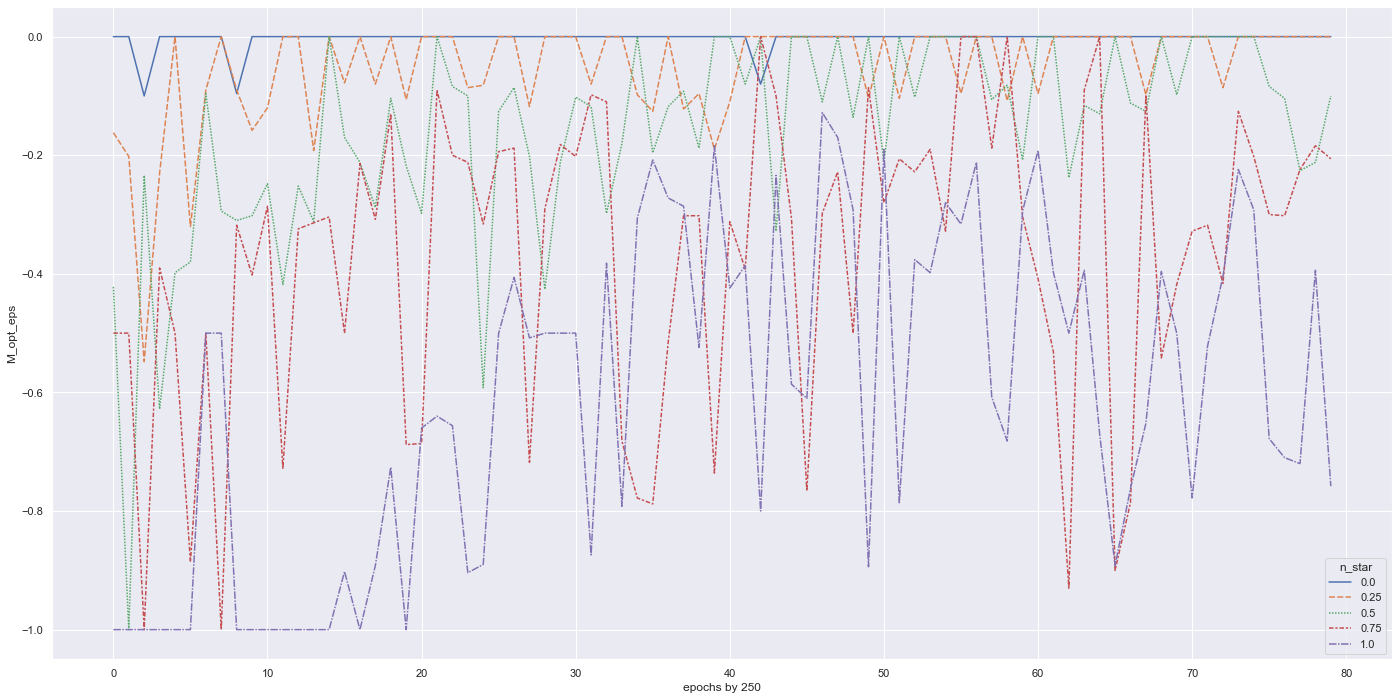

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

M_opt_eps_df = pd.DataFrame(M_opt_eps)
M_opt_eps_df.index.name = 'epochs by 250'
M_opt_eps_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=M_opt_eps_df)
g.set_ylabel('M_opt_eps')

(jl, April 22, 8:00pm) **I think most likely there must be a bug** because it seems quite strange that the eps=0 option would learn to play the opponent perfectly right away after only 250 epochs. I can't remember anymore, but I don't think that is what we observed before? Definitely something to check. Also it seems weird to me that the process is not monotone. Would we not expect to only improve? How come we suddenly get worse? I guess there is some variance due to our epsilon (i.e. sometimes we explore and we don't choose the perfect option) so maybe that explains it?

#Q5
What are the highest values of $M_{opt}$ and $M_{rand}$ that you could achieve after playing 20’000 games?



In [52]:
M_opt_eps_df

n_star,0.00,0.25,0.50,0.75,1.00
epochs by 250,,,,,
0,0.0,-0.162,-0.422,-0.500,-1.000
1,0.0,-0.202,-1.000,-0.500,-1.000
2,-0.1,-0.548,-0.234,-1.000,-1.000
3,0.0,-0.230,-0.628,-0.390,-1.000
4,0.0,0.000,-0.398,-0.500,-1.000
...,...,...,...,...,...
75,0.0,0.000,-0.084,-0.300,-0.678
76,0.0,0.000,-0.104,-0.302,-0.710
77,0.0,0.000,-0.226,-0.224,-0.720


Text(0, 0.5, 'M_rand_eps')

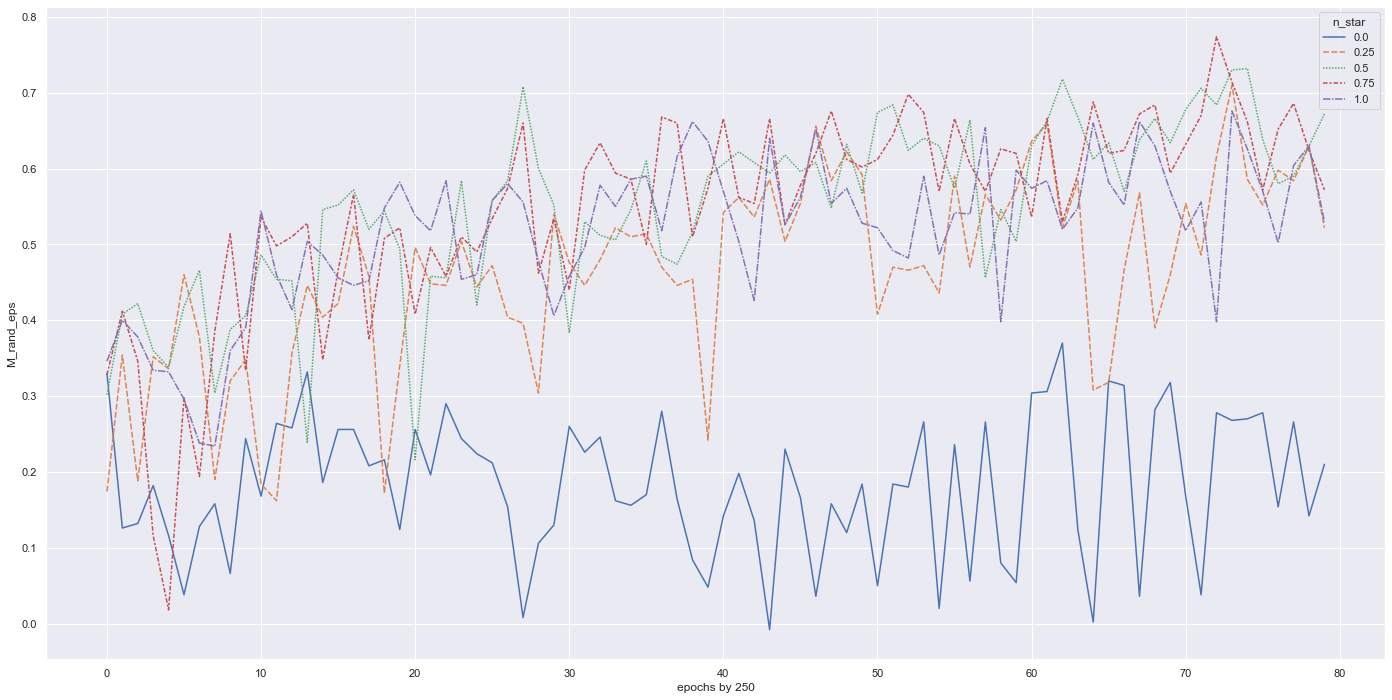

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

M_rand_eps_df = pd.DataFrame(M_rand_eps)
M_rand_eps_df.index.name = 'epochs by 250'
M_rand_eps_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=M_rand_eps_df)
g.set_ylabel('M_rand_eps')

** Again ** it is super weird that the M_rand plot is not a mirror image of the M_opt; i.e. we'd expect that if 0.0 gets great performance again M_opt, it should get great performance here. This is not what seems to be happening though.

# Q6 (answer)
*Question 6. (Theory) Assume that Agent 1 learns by playing against $\text{Opt}(0)$ and find the optimal Q-
values $Q_1(s, a)$. In addition, assume that Agent 2 learns by playing against $\text{Opt}(1)$ and find the optimal
Q-values $Q_2(s, a)$. Do $Q_1(s, a)$ and $Q_2(s, a)$ have the same values? Justify your answer. (answer length
< 150 words)*

No, they will not have the same values. This is because if we play an optimal agent, we will never win and thus never observe a positive reward. Therefore all Q-values will be at best 0. However, playing against a random oponent, we will definitely win sometimes and as we will get closer and closer to convergence, we will play better and better and win more and more. We will therefore definitely observe positive rewards at times. Hence, the Q-values will be different.

# 2.2 Learning by practice
In this section, your are supposed to ask whether Q-learning can learn to play Tic Tac Toe by only
playing against itself. For different values of $\epsilon \in [0, 1)$, run a Q-learning agent against itself for 20’000
games – i.e. both players use the same set of Q-values and update the same set of Q-values.



# Q7 (code below)
*Question 7. After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for different
values of $\epsilon \in [0, 1)$. Does the agent learn to play Tic Tac Toe? What is the effect of $\epsilon$?
Expected answer: A figure showing $M_{opt}$ and $M_{rand}$ over time for different values of $\epsilon \in [0, 1)$ (caption
length < 100 words).*

In [42]:
def run_n_games_against_self(max_games_number, our_player, our_player_new_game_epsilon, update_q_values, progress_print=None):
    _rewards = {'our_player': [None for _ in range(max_games_number)],'opponent': [None for _ in range(max_games_number)]}
    _turns = ['X','O']
    opponent = QLearntPlayer(our_player.game_env, our_player.epsilon,our_player.discount_rate_gamma, our_player.learning_rate_alpha)

    # Ensure they share Q_values... I think this should work but it seems (as of April 22, 8pm)
    # that there is a bug: see more below
    opponent.Q_values = our_player.Q_values


    for game in range(max_games_number):
        if progress_print and game % progress_print == 0:
            print('Game ', game, ' begins.')
        env.reset()
        grid, _, __ = env.observe()
        _turns = _turns[::-1] # Reverse after every game to ensure both sides played equally
        opponent = opponent.prepare_new_game_(_turns[0])
        our_player = q_learnt_player.prepare_new_game_(_turns[1])
        assert opponent.player != our_player.player
        our_player.epsilon = our_player_new_game_epsilon(game_number_n=game)
        opponent.epsilon = our_player_new_game_epsilon(game_number_n=game)

        for turn in range(9):
            opponent_turn = env.current_player == opponent.player
            if opponent_turn:
                chosen_move = opponent.choose_move_(grid)
            else:
                chosen_move = our_player.choose_move_(grid)

            grid, end, winner = env.step(chosen_move, print_grid=False)

            if end:
                update_q_values and q_learnt_player.update_q_values_(grid)
                update_q_values and opponent.update_q_values_(grid)
                _rewards['our_player'][game] = env.reward(our_player.player)
                _rewards['opponent'][game] = env.reward(opponent.player)
                break
            else:
                if opponent_turn:
                    update_q_values and q_learnt_player.update_q_values_(grid)
                else:
                    update_q_values and opponent.update_q_values_(grid)

    return _rewards

In [43]:
max_games = 20000
epoch_size = 250

eps_selfs = np.linspace(0,0.99,num=5)

M_opt_self = {eps_opt: [] for eps_opt in eps_selfs}
M_rand_self = {eps_opt: [] for eps_opt in eps_selfs}

min_epsilon = 0.1
max_epsilon = 0.8

n_star = None
calc_epsilon = None

for eps_s in eps_selfs:
    q_learnt_player = QLearntPlayer(env, epsilon=min_epsilon)
    print('Current eps_s = {}'.format(eps_s))

    for game_epoch in range(max_games//epoch_size):
        calc_epsilon = lambda game_number_n: eps_s
        if game_epoch % 20 == 0:
            print('Game ', game_epoch*epoch_size, ' begins.')

        # Run 250 games with updating Q-vals and observe reward (exec 7)
        run_rewards = run_n_games_against_self(max_games_number=epoch_size, our_player=q_learnt_player, \
            our_player_new_game_epsilon=calc_epsilon, update_q_values=True)

        # Run 500 games for M_opt_self calculation
        M_opt_self_rewards = run_n_games(max_games_number=500, our_player=q_learnt_player, opponent_epsilon=0, \
            our_player_new_game_epsilon=lambda game_number_n: 0, update_q_values=False)
        M_opt_self[eps_s].append(np.average(M_opt_self_rewards))


        # Run 500 games for M_rand_self calculation
        M_rand_self_rewards = run_n_games(max_games_number=500, our_player=q_learnt_player, opponent_epsilon=1, \
            our_player_new_game_epsilon=lambda game_number_n: 0, update_q_values=False)
        M_rand_self[eps_s].append(np.average(M_rand_self_rewards))


Current eps_s = 0.0
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current eps_s = 0.2475
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current eps_s = 0.495
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current eps_s = 0.7424999999999999
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current eps_s = 0.99
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.


Text(0, 0.5, 'M_opt_self')

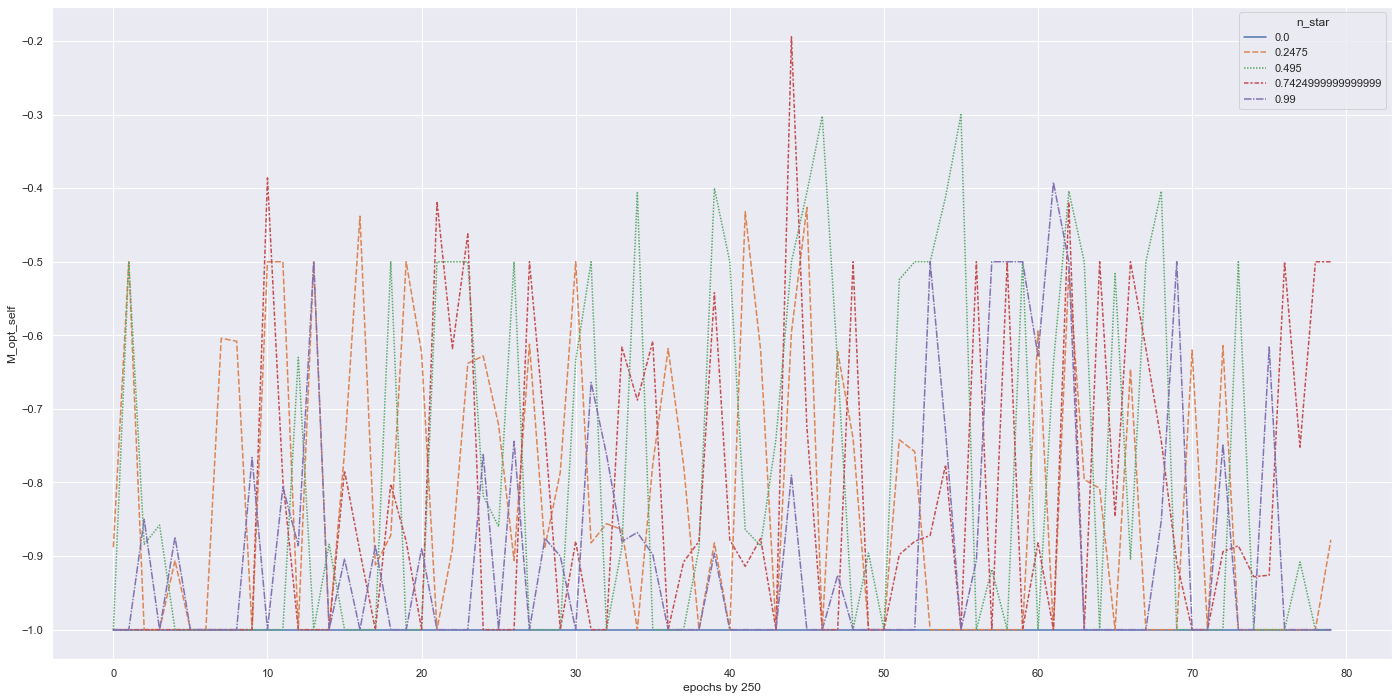

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

M_opt_self_df = pd.DataFrame(M_opt_self)
M_opt_self_df.index.name = 'epochs by 250'
M_opt_self_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=M_opt_self_df)
g.set_ylabel('M_opt_self')

Text(0, 0.5, 'M_opt_self')

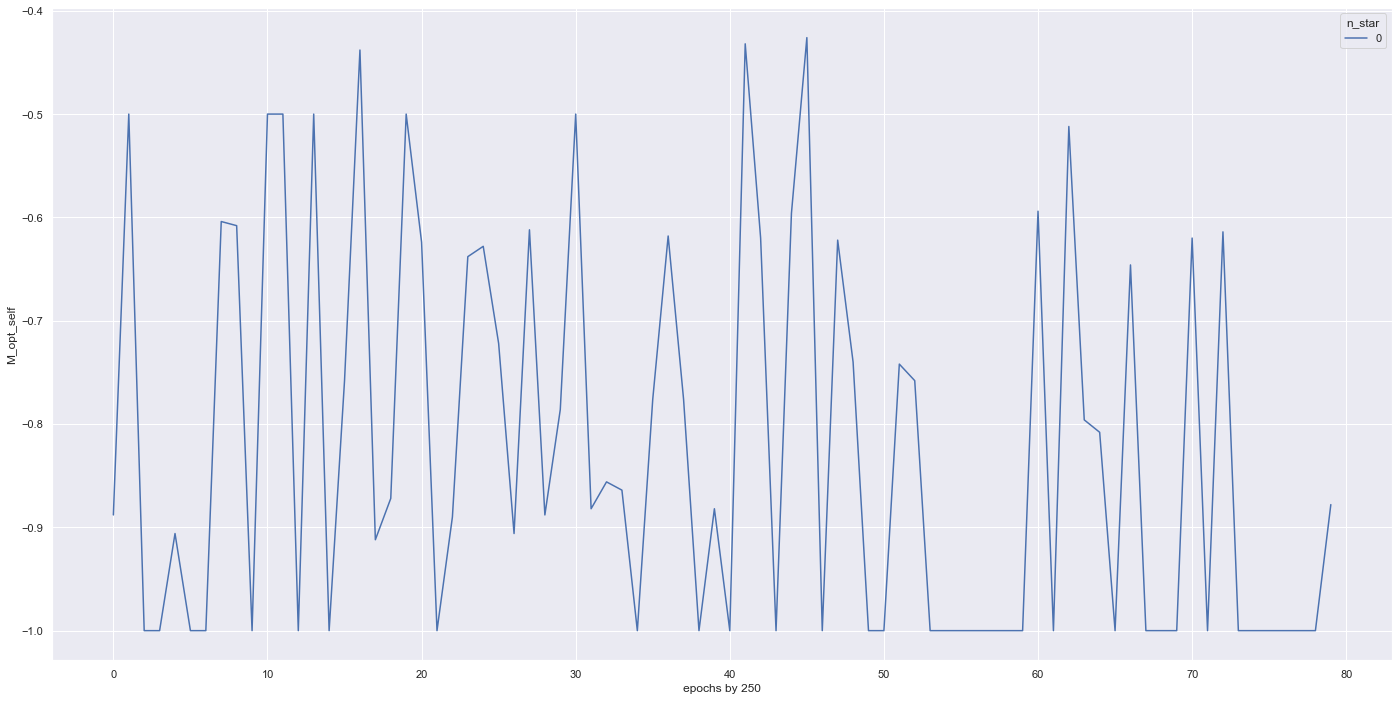

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

M_opt_self_df = pd.DataFrame(M_opt_self[eps_selfs[1]])
M_opt_self_df.index.name = 'epochs by 250'
M_opt_self_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=M_opt_self_df)
g.set_ylabel('M_opt_self')

Text(0, 0.5, 'M_rand_self')

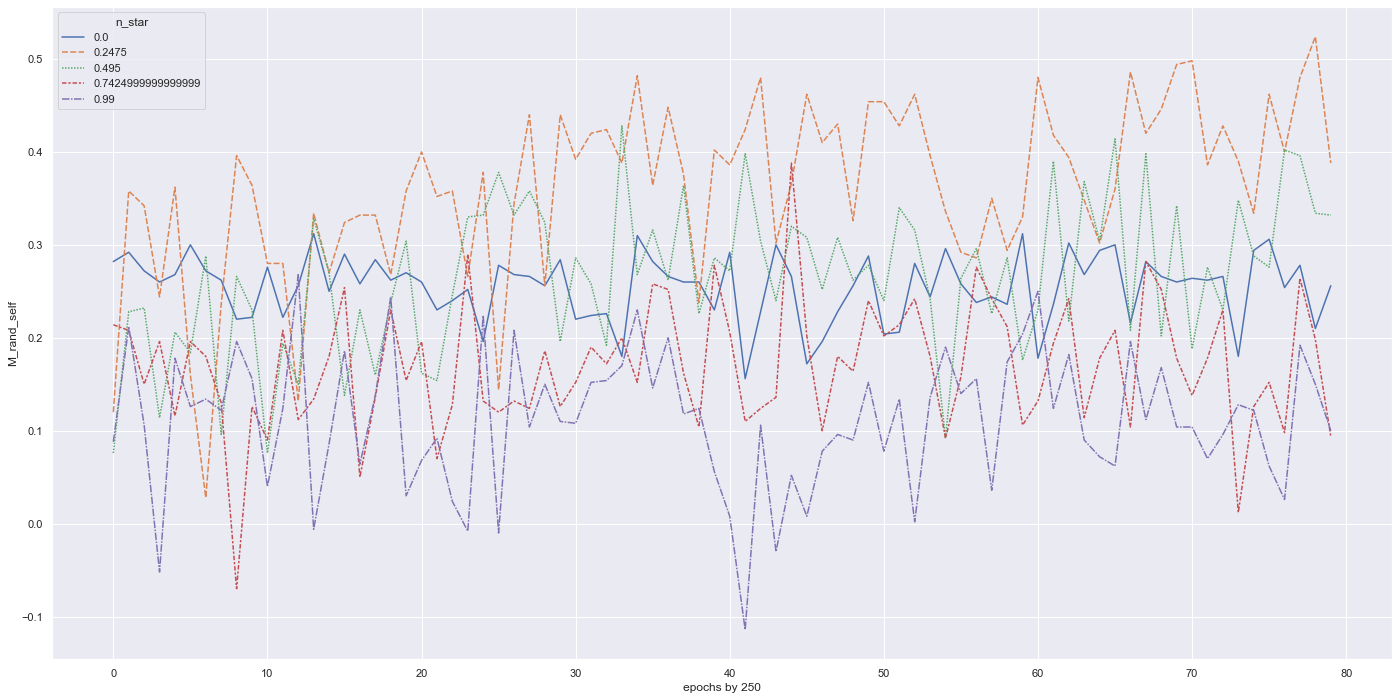

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

M_rand_self_df = pd.DataFrame(M_rand_self)
M_rand_self_df.index.name = 'epochs by 250'
M_rand_self_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=M_rand_self_df)
g.set_ylabel('M_rand_self')

# Q7 (answer)
*Question 7. After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for different
values of $\epsilon \in [0, 1)$. Does the agent learn to play Tic Tac Toe? What is the effect of $\epsilon$?
Expected answer: A figure showing $M_{opt}$ and $M_{rand}$ over time for different values of $\epsilon \in [0, 1)$ (caption
length < 100 words).*

(jl, April 22 8:00 pm) **It seems that there is some bug here** because very little learning seems to be going on. I would expect the agent here to learn at least as well as when playing a random oponent.

# Q8 (code below)
For rest of this section, use $\epsilon(n)$ in Equation 1 with different values of $n^∗$ – instead of fixing $\epsilon$.
Question 8. After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for your agents.
Does decreasing $\epsilon$ help training compared to having a fixed $\epsilon$? What is the effect of $n^∗$?
Expected answer: A figure showing $M_{opt}$ and $M_{rand}$ over time for different values of speeds of $n^∗$ (caption
length < 100 words).

In [48]:
max_games = 20000
n_stars =  np.geomspace(1, 40000, num=4) # Includes 1 and 40000
epoch_size = 250

rewards_self_n_stars = {n_star: {'our_player': [], 'opponent':[]} for n_star in n_stars}
M_opt_self_n_stars = {n_star: [] for n_star in n_stars}
M_rand_self_n_stars = {n_star: [] for n_star in n_stars}

min_epsilon = 0.1
max_epsilon = 0.8
def calc_epsilon_factory(n_star, epoch_size, game_epoch):
        def calc_epsilon(game_number_n):
            real_game_number = game_epoch*epoch_size + game_number_n
            return max(min_epsilon, max_epsilon*(1-(real_game_number/n_star)))
        return calc_epsilon

for n_star in n_stars:
    q_learnt_player = QLearntPlayer(env, epsilon=max_epsilon)
    print('Current n_star = {}'.format(n_star))

    for game_epoch in range(max_games//epoch_size):
        calc_epsilon = calc_epsilon_factory(n_star=n_star, epoch_size=epoch_size, game_epoch=game_epoch)
        if game_epoch % 20 == 0:
            print('Game ', game_epoch*epoch_size, ' begins.')

        # Run 250 games with updating Q-vals and observe reward (exec 8)
        run_rewards = run_n_games_against_self(max_games_number=epoch_size, our_player=q_learnt_player, \
            our_player_new_game_epsilon=calc_epsilon, update_q_values=True)
        rewards_self_n_stars[n_star]['our_player'] += run_rewards['our_player']
        rewards_self_n_stars[n_star]['opponent'] += run_rewards['opponent']

        # Run 500 games for M_opt_self_n_stars calculation
        M_opt_self_n_stars_rewards = run_n_games(max_games_number=500, our_player=q_learnt_player, opponent_epsilon=0, \
            our_player_new_game_epsilon=lambda game_number_n: 0, update_q_values=False)
        M_opt_self_n_stars[n_star].append(np.average(M_opt_self_n_stars_rewards))


        # Run 500 games for M_rand_self_n_stars calculation
        M_rand_self_n_stars_rewards = run_n_games(max_games_number=500, our_player=q_learnt_player, opponent_epsilon=1, \
            our_player_new_game_epsilon=lambda game_number_n: 0, update_q_values=False)
        M_rand_self_n_stars[n_star].append(np.average(M_rand_self_n_stars_rewards))



Current n_star = 1.0
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current n_star = 34.19951893353395
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current n_star = 1169.6070952851471
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.
Current n_star = 40000.0
Game  0  begins.
Game  5000  begins.
Game  10000  begins.
Game  15000  begins.


Text(0, 0.5, 'M_rand_self_n_stars')

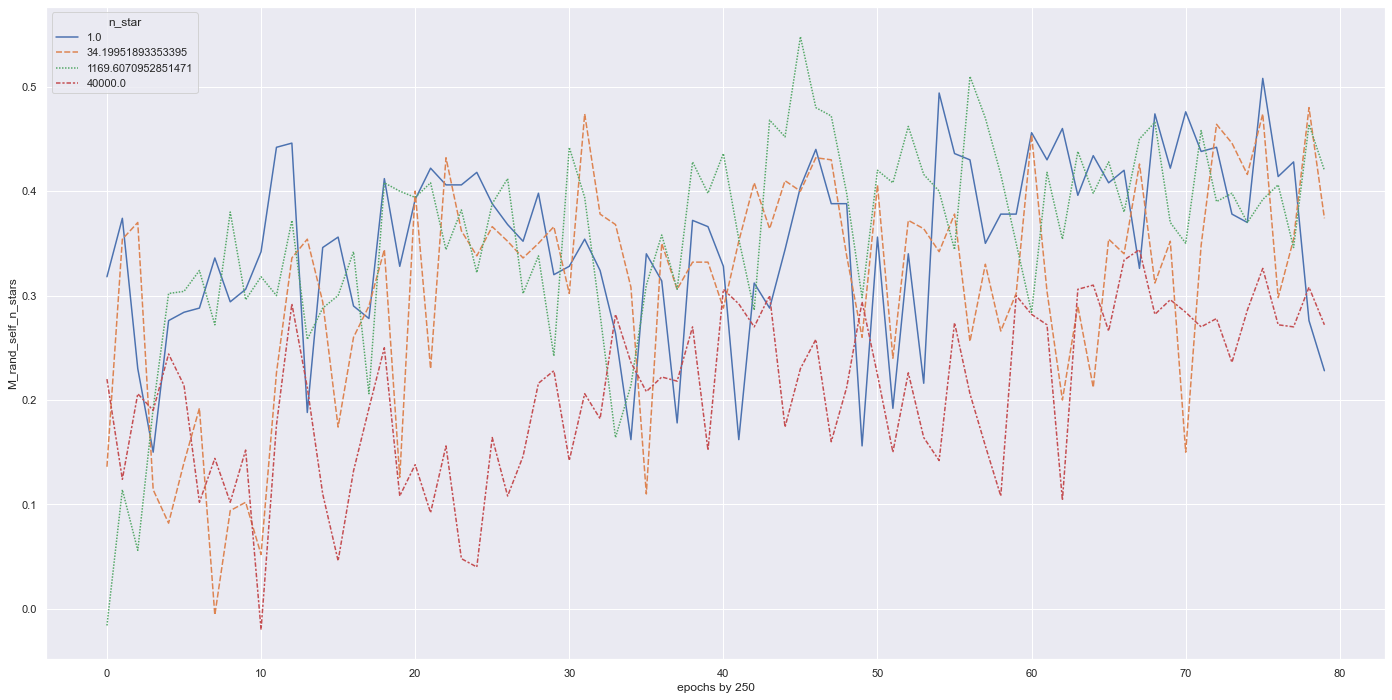

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

M_rand_self_n_stars_df = pd.DataFrame(M_rand_self_n_stars)
M_rand_self_n_stars_df.index.name = 'epochs by 250'
M_rand_self_n_stars_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=M_rand_self_n_stars_df)
g.set_ylabel('M_rand_self_n_stars')

Text(0, 0.5, 'M_opt_self_n_stars')

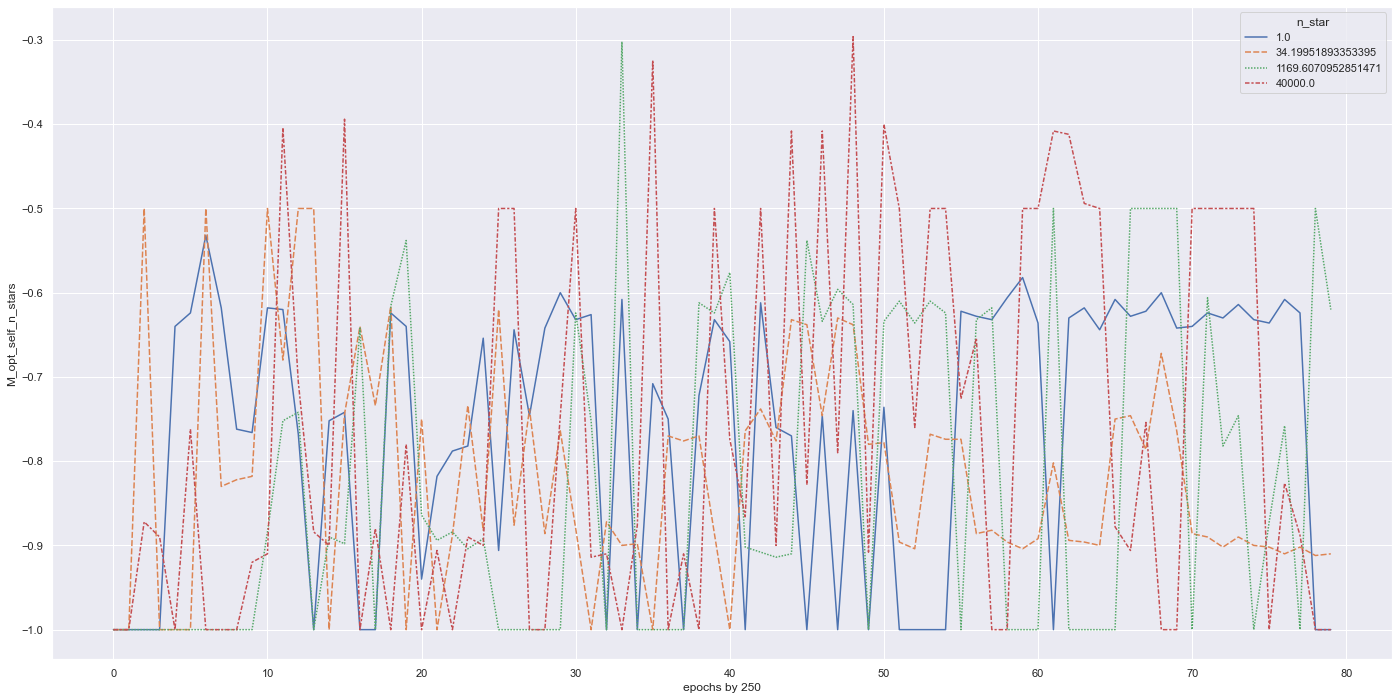

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

M_opt_self_n_stars_df = pd.DataFrame(M_opt_self_n_stars)
M_opt_self_n_stars_df.index.name = 'epochs by 250'
M_opt_self_n_stars_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=M_opt_self_n_stars_df)
g.set_ylabel('M_opt_self_n_stars')

# Q8 (answer)
For rest of this section, use $\epsilon(n)$ in Equation 1 with different values of $n^∗$ – instead of fixing $\epsilon$.
Question 8. After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for your agents.
Does decreasing $\epsilon$ help training compared to having a fixed $\epsilon$? What is the effect of $n^∗$?
Expected answer: A figure showing $M_{opt}$ and $M_{rand}$ over time for different values of speeds of $n^∗$ (caption
length < 100 words).

(jl, April 22 8:00 pm) **Just like in Q7, I think this is buggy** because very little learning seems to be going on. I would expect the agent here to learn at least as well as when playing a random oponent.

# Q9
*Question 9. What are the highest values of $M_{opt}$ and $M_{rand}$ that you could achieve after playing 20’000 games?*

**TODO: Answer once sure the above code is not buggy**

# Q10
*Question 10. For three board arrangements (i.e. states s), visualize Q-values of available actions (e.g.
using heat maps). Does the result make sense? Did the agent learn the game well?
Expected answer: A figure with 3 subplots of 3 different states with Q-values shown at available actions
(caption length < 200 words).*

**TODO: Answer once sure the above code is not buggy**

# 3 Deep Q-Learning
As our 2nd algorithm, we use Deep Q-Learning (DQN) combined with $\epsilon$-greedy policy. You can watch
again Part 1 of Deep Reinforcement Learning Lecture 1 for an introduction to DQN and Part 1 of
Deep Reinforcement Learning Lecture 2 (in particular slide 8) for more details. The idea in DQN is
to approximate Q-values by a neural network instead of a look-up table as in Tabular Q-learning. For
implementation, you can use ideas from the DQN tutorials of Keras and PyTorch.

# 3.2 Learning from experts
Implement the DQN algorithm. To check the algorithm, run a DQN agent with a fixed and arbitrary
$\epsilon \in [0,1)$ against Opt(0.5) for 20’000 games – switch the 1st player after every game.

## Question 11
*Plot average reward and average training loss for every 250 games during training. Does
the loss decrease? Does the agent learn to play Tic Tac Toe?
Expected answer: A figure with two subplots (caption length $<$ 50 words). Specify your choice of $\epsilon$.*